In [1]:
import numpy as np
import pandas as pd
import random
import gc

In [2]:
# train table is soooooo big, need to break it down
num_of_slice = 40

In [3]:
# (train_full["task_container_id"].max()  < np.iinfo(np.int16).max)  \
# & (train_full["task_container_id"].min()  > np.iinfo(np.int16).min)
train_full = pd.read_csv("riiid-test-answer-prediction/train.csv", \
                         dtype={'row_id': 'int64',
                                'timestamp': 'int64', 'user_id': 'int32' , \
                                'content_id': 'int16','content_type_id': 'int8', \
                                'task_container_id':'int16', 'user_answer': 'int8', \
                                'answered_correctly':'int8','prior_question_elapsed_time': 'float32', \
                                'prior_question_had_explanation': 'boolean'})
train_full.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 3.1 GB


In [4]:
questions = pd.read_csv("riiid-test-answer-prediction/questions.csv")
lectures = pd.read_csv("riiid-test-answer-prediction/lectures.csv")
example_test = pd.read_csv("riiid-test-answer-prediction/example_test.csv")

In [5]:
#train_full['user_id']

## Feature Engineering 

#### questions table -> tags, parts and rate of correction

In [6]:
# step 1: one-hot encoding tags

In [7]:
tags = questions["tags"]
tags_split_df = pd.DataFrame([x.split(" ") for x in tags.astype(str)], \
                             columns =['QTag1', 'QTag2','QTag3','QTag4','QTag5','QTag6']).fillna(0)
#tags_split_df = tags_split_df.replace({np.nan: 0})
tags_split_df = tags_split_df.apply(lambda row: pd.to_numeric(row,errors='coerce'), axis=1)
tags_split_df = tags_split_df.replace({np.nan: 0}).astype('int16')

In [8]:
tags_split_df.head()

,QTag1,QTag2,QTag3,QTag4,QTag5,QTag6
0,51,131,162,38,0,0
1,131,36,81,0,0,0
2,131,101,162,92,0,0
3,131,149,162,29,0,0
4,131,5,162,38,0,0


In [9]:
# one hot encoder
def onehot_encoder(tags_split_series, max_tag):
    onehot_encoded = list()
    for value in tags_split_series:
        letter = [0 for _ in range(max_tag+1)]
        letter[value] = 1
        onehot_encoded.append(letter)
    onehot_encoded = pd.DataFrame(onehot_encoded, columns = range(max_tag+1))
    return onehot_encoded

In [10]:
max_tags = tags_split_df.max(axis = 1, skipna = True).max()
onehot_encoded = pd.DataFrame(0, index=np.arange(len(tags_split_df)), columns=range(max_tags+1))
for tags in tags_split_df:
    #print(tags)
    onehot_encoded = onehot_encoded + onehot_encoder(tags_split_df[tags],max_tags)
onehot_encoded.drop(0, axis=1, inplace=True)
onehot_encoded_std = onehot_encoded.div(onehot_encoded.sum(axis=1), axis=0).fillna(0)

In [11]:
# step 2: clustering questions based on tags

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=36).fit(onehot_encoded_std)
questions['tag_cluster'] = pd.Series(kmeans.labels_, index=questions.index)

from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps = 0.5, metric ='cosine').fit(onehot_encoded_std)
questions['tag_cluster'] = pd.Series(clustering.labels_, index=questions.index)
questions.loc[questions['tag_cluster'] == -1, 'tag_cluster'] = max(questions['tag_cluster']) +1 

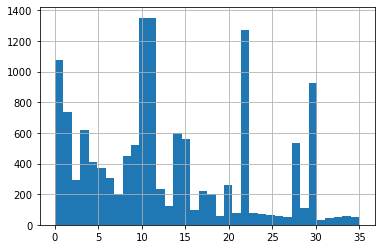

In [13]:
hist = questions['tag_cluster'].hist(bins=36)

In [14]:
# step 3: calcuate correction rate per question + how many users encountered the question

In [15]:
question_answeared = train_full[['content_id','answered_correctly', 'user_id',
                                 'task_container_id','prior_question_elapsed_time']].loc[train_full['content_type_id'] == 0]
question_answeared_summ = \
        pd.DataFrame({'Num_Correction': question_answeared.groupby(['content_id'])['answered_correctly'].agg('sum'),
                      'Count': question_answeared.groupby(['content_id'])['answered_correctly'].agg('count'),
                      'Q_Correction_rate': question_answeared.groupby(['content_id'])['answered_correctly'].agg('sum')/ \
                          question_answeared.groupby(['content_id'])['answered_correctly'].agg('count')}).reset_index()
questions = questions.merge(question_answeared_summ,left_on='question_id', right_on='content_id',how = 'left')
questions.drop('content_id', axis=1, inplace=True)

In [16]:
# step 3: calcuate correction rate per tag/part

In [17]:
tag_cluster_summ = \
        pd.DataFrame({'Tag_Correction_rate': questions.groupby(['tag_cluster'])['Num_Correction'].agg('sum')/ \
                          questions.groupby(['tag_cluster'])['Count'].agg('sum')}).reset_index()
questions = questions.merge(tag_cluster_summ,left_on='tag_cluster', right_on='tag_cluster',how = 'left')

In [18]:
part_summ = \
        pd.DataFrame({'Part_Correction_rate': questions.groupby(['part'])['Num_Correction'].agg('sum')/ \
                          questions.groupby(['part'])['Count'].agg('sum')}).reset_index()
questions = questions.merge(part_summ,left_on='part', right_on='part',how = 'left')

In [19]:
# step 4: how many tags per question?

In [20]:
questions = questions.merge(tags_split_df, left_index = True, right_index = True, how = 'left')

In [21]:
questions['question_n_tags'] = (questions[['QTag1','QTag2','QTag3','QTag4','QTag5','QTag6']] != 0).sum(1).astype('int8')

In [22]:
# step 5: average elapse time

elapse_time = question_answeared[['user_id','task_container_id','prior_question_elapsed_time']]
elapse_time = elapse_time.drop_duplicates()

elapse_time['question_elapsed_time'] = elapse_time.groupby(['user_id'])['prior_question_elapsed_time'].shift(-1)
elapse_time.drop('prior_question_elapsed_time', axis=1, inplace=True)
question_answeared.drop(['prior_question_elapsed_time','answered_correctly'], axis=1, inplace=True)

elapse_time = question_answeared.merge(elapse_time,
                         left_on=['user_id','task_container_id'], 
                         right_on=['user_id','task_container_id'],how = 'left')

elapse_time.dropna(subset=['question_elapsed_time'], inplace = True)

elapse_time_summ = \
     pd.DataFrame({'Q_avg_elapsed_time': elapse_time.groupby(['content_id'])\
                   ['question_elapsed_time'].agg('mean')}).reset_index().astype('float32')

questions = questions.merge(elapse_time_summ, left_on = ['question_id'], right_on = ['content_id'], how = 'left')

In [23]:
questions.to_pickle("./processing_data/questions_prediction.pkl")
questions.drop(['Num_Correction','Count','tags','content_id'], axis=1, inplace=True,errors = 'ignore')

In [24]:
question_answeared=pd.DataFrame()
tag_cluster_summ=pd.DataFrame()
part_summ=pd.DataFrame()
question_answeared_summ=pd.DataFrame()

In [25]:
questions['part']  = questions['part'].astype('int8')
questions['tag_cluster']  = questions['tag_cluster'].astype('int8')
questions['question_id']  = questions['question_id'].astype('int16')
questions['Q_Correction_rate']  = questions['Q_Correction_rate'].astype('float32')
questions['Tag_Correction_rate']  = questions['Tag_Correction_rate'].astype('float32')
questions['Part_Correction_rate']  = questions['Part_Correction_rate'].astype('float32')
questions.to_pickle("./processing_data/questions.pkl")

In [26]:
questions

,question_id,bundle_id,correct_answer,part,tag_cluster,Q_Correction_rate,Tag_Correction_rate,Part_Correction_rate,QTag1,QTag2,QTag3,QTag4,QTag5,QTag6,question_n_tags
0,0,0,0,1,8,0.907721,0.723088,0.745032,51,131,162,38,0,0,4
1,1,1,1,1,10,0.890646,0.706234,0.745032,131,36,81,0,0,0,3
2,2,2,0,1,0,0.554281,0.682275,0.745032,131,101,162,92,0,0,4
3,3,3,0,1,8,0.779437,0.723088,0.745032,131,149,162,29,0,0,4
4,4,4,3,1,8,0.613215,0.723088,0.745032,131,5,162,38,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,13518,3,5,12,0.786866,0.699131,0.610088,14,0,0,0,0,0,1
13519,13519,13519,3,5,1,0.571429,0.619862,0.610088,8,0,0,0,0,0,1
13520,13520,13520,2,5,3,0.672474,0.586561,0.610088,73,0,0,0,0,0,1
13521,13521,13521,0,5,19,0.808046,0.634604,0.610088,125,0,0,0,0,0,1


In [27]:
questions=pd.DataFrame()

#### train table -> train_questions & train_lectures

In [28]:
# capping timestamp_delta

In [29]:
train_full['timestamp_delta']= train_full.groupby(['user_id'])['timestamp'].shift(-1) - train_full['timestamp']
#train_full['timestamp_delta'] = train_full['timestamp_delta'].astype('int32')
train_full['timestamp_delta'].clip(upper=train_full['prior_question_elapsed_time'].quantile(0.95), inplace = True)
train_full['timestamp_delta']  = train_full['timestamp_delta'].astype('float32')

train_full['timestamp_cum'] = train_full.groupby(['user_id'])['timestamp_delta'].cumsum()
train_full['timestamp_cum'] = train_full['timestamp_cum'].astype('float32')

In [30]:
train_questions = train_full.loc[train_full['content_type_id'] == 0]
train_lectures = train_full.loc[train_full['content_type_id'] == 1]

In [31]:
train_full=pd.DataFrame()

In [32]:
train_questions.to_pickle("./processing_data/train_questions.pkl")
train_lectures.to_pickle("./processing_data/train_lectures.pkl")

##### train_lectures

In [33]:
# creating a column for reviewing a lecture before answearing question

In [34]:
train_lectures = pd.read_pickle("./processing_data/train_lectures.pkl")
train_lectures['viewed_lecture_row'] = train_lectures['row_id'] + 1
train_lectures['viewed_lecture'] = train_lectures['content_id']

train_lectures_processed = train_lectures.merge(lectures,left_on='content_id', right_on='lecture_id',how = 'left')
train_lectures_processed['viewed_lecture_count'] = \
                train_lectures_processed.groupby(['user_id'])['viewed_lecture'].cumcount().astype('int8')

In [35]:
train_lectures_processed.rename(columns={"tag": "lecuture_tag", "part": "lecuture_part", 'type_of':'lecuture_type_of'},
                     inplace = True)
train_lectures_processed.drop(['row_id',
                               "user_id", "lecuture_part", 'lecuture_type_of',
                               'timestamp','timestamp_cum','content_type_id','task_container_id',
                    'user_answer','answered_correctly', 'viewed_lecture',
                     'prior_question_had_explanation',
                               'prior_question_elapsed_time',
                    'content_id','timestamp_delta','lecture_id'], axis=1, inplace=True)

In [36]:
train_lectures_processed.head(20)

,viewed_lecture_row,lecuture_tag,viewed_lecture_count
0,90,129,0
1,118,40,0
2,213,43,1
3,217,58,2
4,296,99,0
5,303,164,1
6,324,30,2
7,410,170,0
8,442,39,1
9,487,19,2


In [37]:
train_lectures_processed.to_pickle("./processing_data/train_lectures_processed.pkl")
train_lectures = pd.DataFrame()
train_lectures_processed = pd.DataFrame()
gc

<module 'gc' (built-in)>

##### train_questions

In [3]:
train_lectures = pd.DataFrame()
train_questions = pd.DataFrame()
gc
train_questions = pd.read_pickle("./processing_data/train_questions.pkl")

#### train_questions table 

In [4]:
# question table related features
questions = pd.read_pickle("./processing_data/questions.pkl")
questions.drop(['bundle_id','correct_answer'], axis=1, inplace=True)
train_questions = train_questions.merge(questions,left_on='content_id', right_on='question_id',how = 'left')

In [5]:
# if lecture
train_lectures = pd.read_pickle("./processing_data/train_lectures_processed.pkl")
train_questions = train_questions.merge(train_lectures,left_on='row_id', right_on='viewed_lecture_row',how = 'left')
train_lectures = pd.DataFrame()
gc
train_questions.drop(['viewed_lecture_row'], axis=1, inplace=True)

#### train_question datble is so big that we need to break it down to generate some features

In [6]:
unique_user = train_questions['user_id'].unique()

for num in list(range(1,num_of_slice+1)):
    print("saving ./processing_data/train_questions"+str(num)+".pkl", flush=True)
    split1 = train_questions[train_questions['user_id'] == unique_user[(len(unique_user)//(num_of_slice)) 
                                                                       * (num-1) ]].index[0] - 1
    split2 = train_questions[train_questions['user_id'] == unique_user[len(unique_user)//(num_of_slice) * num]].index[0] - 1
    train_questions_sliced = train_questions.loc[split1 + 1:split2]
    train_questions_sliced.to_pickle("./processing_data/train_questions"+str(num)+".pkl")
    print('slice from '+str(split1 +1 )+" to " + str(split2), flush=True)
    train_questions_sliced = pd.DataFrame()

In [7]:
del train_questions
gc.collect()

60

In [3]:
def if_id_inlist(row):
    if row[0] in [row[1], row[2],row[3], row[4],row[5], row[6]]:
        val = 1
    else:
        val = 0
    return val

In [9]:
for num in list(range(1,num_of_slice+1)):
#for num in list(range(1,2)):
    print("./processing_data/train_questions"+str(num)+".pkl", flush=True)
    train_questions_sliced = pd.read_pickle("./processing_data/train_questions"+str(num)+".pkl").reset_index(drop=True)
    # log of time spend on system
    train_questions_sliced['log_timestamp'] = np.log10(train_questions_sliced['timestamp']+10)
    train_questions_sliced['log_timestamp']  = train_questions_sliced['log_timestamp'].astype('float32')
    #hist = train_questions['log_timestamp'].hist(bins=50)
    train_questions_sliced.drop(['timestamp','content_type_id',
                      #'user_answer'
                     ], axis=1, inplace=True)

    # total question answeared by user
    train_questions_sliced['cum_question_answeared'] = \
                train_questions_sliced.groupby(['user_id'])['answered_correctly'].cumcount()
    train_questions_sliced['cum_question_answeared']  = train_questions_sliced['cum_question_answeared'].astype('int16')

    # total question answeared correctly by user
    train_questions_sliced['cum_answeared_correctly'] = \
        train_questions_sliced.groupby(['user_id'])['answered_correctly'].cumsum()
    train_questions_sliced['cum_answeared_correctly'] = train_questions_sliced.groupby(['user_id'])\
        ['cum_answeared_correctly'].shift(1).replace({np.nan: 0}).astype('int16')

    # cumulative correction rate by user
    train_questions_sliced['cum_correction_rate'] = train_questions_sliced['cum_answeared_correctly'] / \
                train_questions_sliced['cum_question_answeared']
    train_questions_sliced['cum_correction_rate']  = train_questions_sliced['cum_correction_rate'].astype('float32')

    # rolling correction rate by user
#     train_questions_sliced['moving_correction_rate_5'] = train_questions_sliced.groupby('user_id')['answered_correctly']\
#         .rolling(5).mean().reset_index(drop=True)
#     train_questions_sliced['moving_correction_rate_5'] = train_questions_sliced.groupby('user_id')['moving_correction_rate_5']\
#         .shift(1).astype('float32')
    
#     train_questions_sliced['moving_correction_rate_10'] = train_questions_sliced.groupby('user_id')['answered_correctly']\
#         .rolling(5).mean().reset_index(drop=True)
#     train_questions_sliced['moving_correction_rate_10'] = train_questions_sliced.groupby('user_id')\
#             ['moving_correction_rate_10']\
#         .shift(1).astype('float32')
    
#     train_questions_sliced['moving_correction_rate_15'] = train_questions_sliced.groupby('user_id')['answered_correctly']\
#         .rolling(5).mean().reset_index(drop=True)
#     train_questions_sliced['moving_correction_rate_15'] = train_questions_sliced.groupby('user_id')\
#             ['moving_correction_rate_15']\
#         .shift(1).astype('float32')
    
    # prior questions correct or not
    train_questions_sliced['answered_correctly_1'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(1).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_1'] == 3, 'answered_correctly_1'] = np.nan
    
    train_questions_sliced['answered_correctly_2'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(2).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_2'] == 3, 'answered_correctly_2'] = np.nan    
    
    train_questions_sliced['answered_correctly_3'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(3).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_3'] == 3, 'answered_correctly_3'] = np.nan
    
    train_questions_sliced['answered_correctly_4'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(4).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_4'] == 3, 'answered_correctly_4'] = np.nan
    
    train_questions_sliced['answered_correctly_5'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(5).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_5'] == 3, 'answered_correctly_5'] = np.nan
    
    train_questions_sliced['answered_correctly_6'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(6).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_6'] == 3, 'answered_correctly_6'] = np.nan
    
    train_questions_sliced['answered_correctly_7'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(7).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_7'] == 3, 'answered_correctly_7'] = np.nan
    
    train_questions_sliced['answered_correctly_8'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(8).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_8'] == 3, 'answered_correctly_8'] = np.nan
    
    train_questions_sliced['answered_correctly_9'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(9).fillna(3).astype('int8')
    #train_questions_sliced.loc[train_questions_sliced['answered_correctly_9'] == 3, 'answered_correctly_9'] = np.nan
    
    # if prior question had explanation
    train_questions_sliced.loc[train_questions_sliced['prior_question_had_explanation'] == True, 'pq_exp'] = 1
    train_questions_sliced.loc[train_questions_sliced['prior_question_had_explanation'] == False, 'pq_exp'] = 2
    train_questions_sliced.loc[train_questions_sliced['prior_question_had_explanation'].isna(), 'pq_exp'] = 3
    train_questions_sliced['pq_exp'] = train_questions_sliced['pq_exp'].astype('int8')

    # questions per container
    train_questions_sliced['n_q_container'] = train_questions_sliced.groupby(['user_id', \
                                                    'task_container_id'])['user_id'].transform('count').astype('int8')
    
    #lectured
    train_questions_sliced['lecuture_tag_filled'] = train_questions_sliced.groupby('user_id')['lecuture_tag'].fillna(method='ffill')

    #train_questions['same_id'] = train_questions.apply(if_id_inlist, axis=1)
    train_questions_sliced['same_id'] = [if_id_inlist(row) for row in zip(train_questions_sliced['lecuture_tag_filled'], \
                                                               train_questions_sliced['QTag1'],train_questions_sliced['QTag2'],
                                                               train_questions_sliced['QTag3'],train_questions_sliced['QTag4'],
                                                               train_questions_sliced['QTag5'],train_questions_sliced['QTag6'])]
    train_questions_sliced['same_id'] = train_questions_sliced['same_id'].astype('int8')

    train_questions_sliced['viewed_lecture_count'] = train_questions_sliced.groupby('user_id')['viewed_lecture_count'].\
                                                    fillna(method='ffill')
    train_questions_sliced['same_id_sum'] = train_questions_sliced.groupby(['user_id', 'viewed_lecture_count'])\
                                            ['same_id'].cumsum()
    train_questions_sliced['same_id_count'] = train_questions_sliced.groupby(['user_id', 'viewed_lecture_count'])\
                                                ['same_id'].cumcount()+1

    train_questions_sliced['if_lectured'] = (train_questions_sliced['same_id_sum'] == \
                                             train_questions_sliced['same_id_count']).astype('int8')
    
    train_questions_sliced['viewed_lecture_count'] = \
            train_questions_sliced['viewed_lecture_count'].fillna(0).astype('float32')
    
    # total question answeared by user and part
    #train_questions_sliced.sort_values(by=['user_id', 'part','row_id'],inplace=True)
    train_questions_sliced['cum_question_answeared_P'] = train_questions_sliced.groupby(['user_id', 'part'])\
                                                            ['answered_correctly'].cumcount()
    train_questions_sliced['cum_question_answeared_P']  = train_questions_sliced['cum_question_answeared_P'].astype('int16')

    # total question answeared correctly by user and part
    train_questions_sliced['cum_answeared_correctly_P'] = \
        train_questions_sliced.groupby(['user_id', 'part'])['answered_correctly'].cumsum()
    train_questions_sliced['cum_answeared_correctly_P'] = \
                        train_questions_sliced.groupby(['user_id','part'])['cum_answeared_correctly_P']\
                                                .shift(1).replace({np.nan: 0}).astype('int16')
    
    # cumulative correction rate by user and part
    train_questions_sliced['cum_correction_rate_P'] = train_questions_sliced['cum_answeared_correctly_P'] / \
                                            train_questions_sliced['cum_question_answeared_P']
    train_questions_sliced['cum_correction_rate_P']  = train_questions_sliced['cum_correction_rate_P'].astype('float32')

    # total question answeared by user and tag_cluster
    #train_questions_sliced.sort_values(by=['user_id', 'tag_cluster','row_id'],inplace=True)
    train_questions_sliced['cum_question_answeared_T'] = train_questions_sliced.groupby(['user_id', \
                                                                       'tag_cluster'])['answered_correctly'].cumcount()
    train_questions_sliced['cum_question_answeared_T']  = train_questions_sliced['cum_question_answeared_T'].astype('int16')

    # total question answeared correctly by user and tag_cluster
    train_questions_sliced['cum_answeared_correctly_T'] = \
        train_questions_sliced.groupby(['user_id', 'tag_cluster'])['answered_correctly'].cumsum()
                    
    train_questions_sliced['cum_answeared_correctly_T'] = \
                                train_questions_sliced.groupby(['user_id', 'tag_cluster'])['cum_answeared_correctly_T']\
                                .shift(1).replace({np.nan: 0}).astype('int16')
    
    # cumulative correction rate by user and tag_cluster
    train_questions_sliced['cum_correction_rate_T'] = train_questions_sliced['cum_answeared_correctly_T'] / \
                                            train_questions_sliced['cum_question_answeared_T']
    train_questions_sliced['cum_correction_rate_T']  = train_questions_sliced['cum_correction_rate_T'].astype('float32')
    
    train_questions_sliced.sort_values(by=['row_id'],inplace=True)
    
    # if encounter the question for the first time?
    train_questions_sliced.sort_values(by=['user_id','question_id','row_id'],inplace=True)
    train_questions_sliced['n_enconter'] = train_questions_sliced.groupby(['user_id', 'question_id'])['row_id'].cumcount()
    train_questions_sliced['if_1st_enconter'] = (train_questions_sliced['n_enconter'] == 0).astype('int8')
    train_questions_sliced.sort_values(by=['user_id','row_id'],inplace=True)
    train_questions_sliced['n_enconter']  = train_questions_sliced['n_enconter'].astype('int8')
    
    # drop some features which were not used in the model
    train_questions_sliced.drop(['Q_avg_elapsed_time',
                      'timestamp_delta',
                      #'cum_question_answeared',
                                 'prior_question_elapsed_time'
                      'cum_answeared_correctly',
                    'cum_question_answeared_P',
                                 'cum_question_answeared_T',
                                 'cum_answeared_correctly_P',
                                 'cum_answeared_correctly_T',
                'Tag_Correction_rate', 
                'Part_Correction_rate', 
                'cum_correction_rate_P_ratio',
                'cum_correction_rate_T_ratio', 
                'n_q_container',
                'count_lecture_tags',
                'count_lecture_tags_short',
                'Q_Correction_rate_count_lecture_tags',
                'Q_Correction_rate_count_lecture_tags_short',
                'valuation_questions',
                'n_enconter',
                 'lecuture_tag_filled','lecuture_tag','same_id_sum','same_id_count',
                     'same_id',
                    'QTag1','QTag2','QTag3','QTag4','QTag5','QTag6',
                  'task_container_id', 
                 'content_id',
                 'prior_question_had_explanation',
                      'timestamp_cum','question_id',
                      'lectured_short'], axis=1, inplace=True,errors = 'ignore')
    
    train_questions_sliced.to_pickle("./processing_data/train_questions_processed"+str(num)+".pkl")

./processing_data/train_questions1.pkl
./processing_data/train_questions2.pkl
./processing_data/train_questions3.pkl
./processing_data/train_questions4.pkl
./processing_data/train_questions5.pkl
./processing_data/train_questions6.pkl
./processing_data/train_questions7.pkl
./processing_data/train_questions8.pkl
./processing_data/train_questions9.pkl
./processing_data/train_questions10.pkl
./processing_data/train_questions11.pkl
./processing_data/train_questions12.pkl
./processing_data/train_questions13.pkl
./processing_data/train_questions14.pkl
./processing_data/train_questions15.pkl
./processing_data/train_questions16.pkl
./processing_data/train_questions17.pkl
./processing_data/train_questions18.pkl
./processing_data/train_questions19.pkl
./processing_data/train_questions20.pkl
./processing_data/train_questions21.pkl
./processing_data/train_questions22.pkl
./processing_data/train_questions23.pkl
./processing_data/train_questions24.pkl
./processing_data/train_questions25.pkl
./process

In [10]:
train_questions_sliced.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2438589 entries, 0 to 2438588
Data columns (total 28 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   row_id                       int64  
 1   user_id                      int32  
 2   user_answer                  int8   
 3   answered_correctly           int8   
 4   prior_question_elapsed_time  float32
 5   part                         int8   
 6   tag_cluster                  int8   
 7   Q_Correction_rate            float32
 8   question_n_tags              int8   
 9   viewed_lecture_count         float32
 10  log_timestamp                float32
 11  cum_question_answeared       int16  
 12  cum_answeared_correctly      int16  
 13  cum_correction_rate          float32
 14  answered_correctly_1         int8   
 15  answered_correctly_2         int8   
 16  answered_correctly_3         int8   
 17  answered_correctly_4         int8   
 18  answered_correctly_5         int8   
 19  

In [11]:
#train_questions_sliced[['user_id', 'row_id','answered_correctly','moving_correction_rate']][45:80]

In [12]:
train_questions_processed = pd.read_pickle("./processing_data/train_questions_processed1.pkl")

for num in list(range(2,num_of_slice+1)):
    if num%10 == 0:
        print("read ./processing_data/train_questions_processed"+str(num)+".pkl", flush=True)
    train_questions_sliced = pd.read_pickle("./processing_data/train_questions_processed"+str(num)+".pkl")
    train_questions_processed = train_questions_processed.append(train_questions_sliced).reset_index(drop=True)
    train_questions_sliced = pd.DataFrame()

read ./processing_data/train_questions_processed10.pkl
read ./processing_data/train_questions_processed20.pkl
read ./processing_data/train_questions_processed30.pkl
read ./processing_data/train_questions_processed40.pkl


In [13]:
train_questions_processed

,row_id,user_id,user_answer,answered_correctly,prior_question_elapsed_time,part,tag_cluster,Q_Correction_rate,question_n_tags,viewed_lecture_count,...,answered_correctly_5,answered_correctly_6,answered_correctly_7,answered_correctly_8,answered_correctly_9,pq_exp,if_lectured,cum_correction_rate_P,cum_correction_rate_T,if_1st_enconter
0,0,115,3,1,NaN,5,13,0.745495,1,0.0,...,3,3,3,3,3,3,0,NaN,NaN,1
1,1,115,2,1,37000.0,5,13,0.734901,1,0.0,...,3,3,3,3,3,2,0,1.000000,1.000000,1
2,2,115,0,1,55000.0,1,32,0.966869,3,0.0,...,3,3,3,3,3,2,0,NaN,NaN,1
3,3,115,0,1,19000.0,1,32,0.954815,3,0.0,...,3,3,3,3,3,2,0,1.000000,1.000000,1
4,4,115,1,1,11000.0,1,32,0.953218,3,0.0,...,3,3,3,3,3,2,0,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99269385,101228401,2147419988,0,1,17000.0,5,9,0.729846,1,43.0,...,1,1,0,1,1,1,0,0.380091,0.200000,1
99269386,101228402,2147419988,3,1,30000.0,5,27,0.679293,1,43.0,...,1,1,1,0,1,1,0,0.382883,0.000000,1
99269387,101228403,2147419988,2,1,30000.0,5,23,0.622465,1,43.0,...,0,1,1,1,0,1,0,0.385650,0.571429,1
99269388,101228404,2147419988,3,1,10000.0,5,23,0.563694,1,43.0,...,0,0,1,1,1,1,0,0.388393,0.625000,1


In [14]:
train_questions_processed.info(memory_usage="deep")
#train_questions_processed.to_pickle("./processing_data/train_questions_processed"+ ".pkl")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99269390 entries, 0 to 99269389
Data columns (total 28 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   row_id                       int64  
 1   user_id                      int32  
 2   user_answer                  int8   
 3   answered_correctly           int8   
 4   prior_question_elapsed_time  float32
 5   part                         int8   
 6   tag_cluster                  int8   
 7   Q_Correction_rate            float32
 8   question_n_tags              int8   
 9   viewed_lecture_count         float32
 10  log_timestamp                float32
 11  cum_question_answeared       int16  
 12  cum_answeared_correctly      int16  
 13  cum_correction_rate          float32
 14  answered_correctly_1         int8   
 15  answered_correctly_2         int8   
 16  answered_correctly_3         int8   
 17  answered_correctly_4         int8   
 18  answered_correctly_5         int8   
 19

## split train/test

read and comibne processe train questions

In [15]:
train_questions_processed['pct_count'] = train_questions_processed.groupby(['user_id'])['row_id'].cumcount()/ \
                    train_questions_processed.groupby(['user_id'])['user_id'].transform('count')
train_questions_processed['Train'] = train_questions_processed['pct_count'] < 0.9

In [16]:
#unique_user = train_questions['user_id'].unique()
random.seed(8848)
test_user = random.choices(unique_user, k = len(unique_user)//20)
train_questions_processed.loc[train_questions_processed['user_id'].isin(test_user), 'Train'] = False

In [17]:
train_questions_processed.drop(['pct_count','row_id'
                      #, 'user_id'
                     ], axis=1, inplace=True)

In [18]:
train_questions_processed.drop(['user_answer','prior_question_elapsed_time',
                      'timestamp_delta', 'cum_correction_rate_P_ratio','cum_correction_rate_T_ratio',
                      'cum_answeared_correctly_T' , 'cum_answeared_correctly_P', 
                      'cum_question_answeared_T', 'cum_question_answeared_P'
                     ], axis=1, inplace=True,errors = 'ignore')

In [19]:
train_questions_processed.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99269390 entries, 0 to 99269389
Data columns (total 26 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   user_id                  int32  
 1   answered_correctly       int8   
 2   part                     int8   
 3   tag_cluster              int8   
 4   Q_Correction_rate        float32
 5   question_n_tags          int8   
 6   viewed_lecture_count     float32
 7   log_timestamp            float32
 8   cum_question_answeared   int16  
 9   cum_answeared_correctly  int16  
 10  cum_correction_rate      float32
 11  answered_correctly_1     int8   
 12  answered_correctly_2     int8   
 13  answered_correctly_3     int8   
 14  answered_correctly_4     int8   
 15  answered_correctly_5     int8   
 16  answered_correctly_6     int8   
 17  answered_correctly_7     int8   
 18  answered_correctly_8     int8   
 19  answered_correctly_9     int8   
 20  pq_exp                   int8   
 21  if_lec

In [20]:
train_questions_processed.to_pickle("./processing_data/train_questions_processed"+ ".pkl")

## Process user data for uploading

user lst obs

In [9]:
for num in list(range(1,num_of_slice+1)):
#for num in list(range(1,2)):
#for num in list(range(num_of_slice,num_of_slice+1)):
    print("./processing_data/train_questions"+str(num)+".pkl", flush=True)
    train_questions_sliced = pd.read_pickle("./processing_data/train_questions"+str(num)+".pkl").reset_index(drop=True)
    
    # prior questions correct or not
    train_questions_sliced['answered_correctly_1'] = train_questions_sliced['answered_correctly']
    
    train_questions_sliced['answered_correctly_2'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(1).fillna(3).astype('int8') 
    
    train_questions_sliced['answered_correctly_3'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(2).fillna(3).astype('int8')
    
    train_questions_sliced['answered_correctly_4'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(3).fillna(3).astype('int8')
    
    train_questions_sliced['answered_correctly_5'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(4).fillna(3).astype('int8')
    
    train_questions_sliced['answered_correctly_6'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(5).fillna(3).astype('int8')
    
    train_questions_sliced['answered_correctly_7'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(6).fillna(3).astype('int8')
    
    train_questions_sliced['answered_correctly_8'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(7).fillna(3).astype('int8')
    
    train_questions_sliced['answered_correctly_9'] = train_questions_sliced.groupby(['user_id'])\
        ['answered_correctly'].shift(8).fillna(3).astype('int8')
    
    #lectured?
    train_questions_sliced['lecuture_tag_filled'] = train_questions_sliced['lecuture_tag'].fillna(method='ffill')

    #train_questions['same_id'] = train_questions.apply(if_id_inlist, axis=1)
    train_questions_sliced['same_id'] = [if_id_inlist(row) for row in zip(train_questions_sliced['lecuture_tag_filled'], \
                                                               train_questions_sliced['QTag1'],train_questions_sliced['QTag2'],
                                                               train_questions_sliced['QTag3'],train_questions_sliced['QTag4'],
                                                               train_questions_sliced['QTag5'],train_questions_sliced['QTag6'])]
    train_questions_sliced['same_id'] = train_questions_sliced['same_id'].astype('int8')

    train_questions_sliced['viewed_lecture_count'] = train_questions_sliced['viewed_lecture_count'].\
                                                    fillna(method='ffill')
    train_questions_sliced['same_id_sum'] = train_questions_sliced.groupby(['user_id', 'viewed_lecture_count'])\
                                            ['same_id'].cumsum()
    train_questions_sliced['same_id_count'] = train_questions_sliced.groupby(['user_id', 'viewed_lecture_count'])\
                                                ['same_id'].cumcount()+1

    train_questions_sliced['if_lectured'] = (train_questions_sliced['same_id_sum'] == \
                                             train_questions_sliced['same_id_count']).astype('int8')
    
    # save last obs
    train_questions_sliced['count'] = train_questions_sliced.groupby(['user_id'])['row_id'].cumcount()
    train_questions_sliced['total_count'] = train_questions_sliced.groupby(['user_id'])['user_id'].transform('count')
    train_questions_sliced_lst = train_questions_sliced.loc[train_questions_sliced['total_count'] -1 == \
                                                            train_questions_sliced['count'], 
                                                            ['user_id', 
                                                             'lecuture_tag_filled', 
                                                             'if_lectured', 'viewed_lecture_count',
                                                               'answered_correctly_1',
    'answered_correctly_2',
    'answered_correctly_3',
    'answered_correctly_4',
    'answered_correctly_5',
    'answered_correctly_6',
    'answered_correctly_7',
    'answered_correctly_8',
    'answered_correctly_9']]
    
    train_questions_sliced_lst.to_pickle("./processing_data/train_questions_sliced_lst"+str(num)+".pkl")

./processing_data/train_questions1.pkl
./processing_data/train_questions2.pkl
./processing_data/train_questions3.pkl
./processing_data/train_questions4.pkl
./processing_data/train_questions5.pkl
./processing_data/train_questions6.pkl
./processing_data/train_questions7.pkl
./processing_data/train_questions8.pkl
./processing_data/train_questions9.pkl
./processing_data/train_questions10.pkl
./processing_data/train_questions11.pkl
./processing_data/train_questions12.pkl
./processing_data/train_questions13.pkl
./processing_data/train_questions14.pkl
./processing_data/train_questions15.pkl
./processing_data/train_questions16.pkl
./processing_data/train_questions17.pkl
./processing_data/train_questions18.pkl
./processing_data/train_questions19.pkl
./processing_data/train_questions20.pkl
./processing_data/train_questions21.pkl
./processing_data/train_questions22.pkl
./processing_data/train_questions23.pkl
./processing_data/train_questions24.pkl
./processing_data/train_questions25.pkl
./process

In [10]:
train_questions_lst = pd.read_pickle("./processing_data/train_questions_sliced_lst1.pkl")

for num in list(range(2,num_of_slice+1)):
    if num%10 == 0:
        print("read ./processing_data/train_questions_sliced_lst"+str(num)+".pkl", flush=True)
    train_questions_sliced = pd.read_pickle("./processing_data/train_questions_sliced_lst"+str(num)+".pkl")
    train_questions_lst = train_questions_lst.append(train_questions_sliced).reset_index(drop=True)
    train_questions_sliced = pd.DataFrame()

train_questions_lst.to_pickle("./processing_data/user_lst.pkl")

read ./processing_data/train_questions_sliced_lst10.pkl
read ./processing_data/train_questions_sliced_lst20.pkl
read ./processing_data/train_questions_sliced_lst30.pkl
read ./processing_data/train_questions_sliced_lst40.pkl


In [34]:
train_questions_lst

,user_id,lecuture_tag_filled,if_lectured,answered_correctly_1,answered_correctly_2,answered_correctly_3,answered_correctly_4,answered_correctly_5,answered_correctly_6,answered_correctly_7,answered_correctly_8,answered_correctly_9
0,115,NaN,0,1,0,0,0,1,1,1,1,1
1,124,NaN,0,0,0,0,0,0,0,0,1,0
2,2746,129.0,0,1,0,1,1,0,1,0,1,1
3,5382,58.0,0,0,0,0,1,1,0,1,1,1
4,8623,30.0,0,1,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
393635,2147406199,174.0,0,0,0,0,1,0,0,1,0,0
393636,2147413636,114.0,0,0,1,1,0,1,1,1,1,1
393637,2147415186,114.0,0,0,1,1,0,1,1,1,1,1
393638,2147415482,114.0,0,0,1,1,1,1,0,1,1,1


#### train_questions table 

In [4]:
train_lectures = pd.DataFrame()
train_questions = pd.DataFrame()
gc
train_questions = pd.read_pickle("./processing_data/train_questions.pkl")

In [5]:
# question table related features
questions = pd.read_pickle("./processing_data/questions.pkl")
questions.drop(['bundle_id','correct_answer'], axis=1, inplace=True)
train_questions = train_questions.merge(questions,left_on='content_id', right_on='question_id',how = 'left')

In [6]:
# if lecture
train_lectures = pd.read_pickle("./processing_data/train_lectures_processed.pkl")
train_questions = train_questions.merge(train_lectures,left_on='row_id', right_on='viewed_lecture_row',how = 'left')
train_lectures = pd.DataFrame()
gc
train_questions.drop(['viewed_lecture_row'], axis=1, inplace=True)

In [7]:
user = train_questions.groupby(['user_id']).\
                    agg(cum_question_answeared=('answered_correctly', 'count'), 
                        cum_question_correctly=('answered_correctly', 'sum')).reset_index()
user.to_pickle("./processing_data/user_correct_count.pkl")

user_tag = train_questions.groupby(['user_id', 'tag_cluster']).\
                    agg(cum_question_answeared_tag=('answered_correctly', 'count'), 
                        cum_question_correctly_tag=('answered_correctly', 'sum')).reset_index()
user_tag.to_pickle("./processing_data/user_tag_correct_count.pkl")

user_part = train_questions.groupby(['user_id', 'part']).\
                    agg(cum_question_answeared_part=('answered_correctly', 'count'), 
                        cum_question_correctly_part=('answered_correctly', 'sum')).reset_index()
user_part.to_pickle("./processing_data/user_part_correct_count.pkl")

In [ ]:
user_questions = train_questions[['user_id','content_id']].drop_duplicates().reset_index(drop = True)
user_questions.to_pickle("./processing_data/user_questions.pkl")